In [1]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

## Load the Data

We will use the [Alphabet Inc.(Google)](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) dataset. The time period used is `('2004-08-19', '2020-12-24')`.

In [4]:
df = pd.read_csv('Stocks\IBM_Scaled2.csv') # Upscaled means removing first 1962-1970 yrs of data and repeating last 2004-2023 data 5 times.

## Quick look at data

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/3/1983,22.645794,23.183556,22.108030,22.227533,7.400015,3182350
1,1/4/1983,22.466539,22.854923,22.078156,22.854923,7.608884,3828778
2,1/5/1983,22.914675,23.123804,22.705545,22.944551,7.638726,3978566
3,1/6/1983,23.183556,23.542065,22.825048,23.332935,7.768023,4285253
4,1/7/1983,23.303059,23.512190,23.064054,23.093929,7.688452,4437550


In [10]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close', 'Volume']]
df['index'] = df.index

In [11]:
# Concise summary of a DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34617 entries, 0 to 34616
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    34617 non-null  object 
 1   Close   34617 non-null  float64
 2   Volume  34617 non-null  int64  
 3   index   34617 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ MB


**Data Time Period**

In [12]:
df['Date'].min(), df['Date'].max()

('1/10/1983', '9/9/2022')

## Visualize the data

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['index'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Close Price')
fig.show()
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df['index'], y=df['Volume'], name='Volume'))
fig2.update_layout(showlegend=True, title='Volume')
fig2.show()

## Data Preprocessing

In [17]:
# # create a differenced series
# def difference(dataset, interval=1):
#     diff = list()
#     for i in range(0, len(dataset)):
#         value = np.nan if i-interval < 0  else dataset[i] - dataset[i - interval] 
#         diff.append(value)
#     return np.array(diff)

# interval =1 # For differencing technique
# df['Diff_Close'] = difference(df['Close'].values,interval)
# df['Diff_Volume'] = difference(df['Volume'].values,interval)
# df = df[interval:]

In [ ]:
class NumericalNormalizer:
    def __init__(self, fields: list):
        self.metrics = {}
        self.fields = fields

    def fit(self, df: pd.DataFrame ) -> list:
        means = df[self.fields].mean()
        std = df[self.fields].std()
        for field in self.fields:
            field_mean = means[field]
            field_stddev = std[field]
            self.metrics[field] = {'mean': field_mean, 'std': field_stddev}

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        # Transform to zero-mean and unit variance.
        for field in self.fields:
            f_mean = self.metrics[field]['mean']
            f_stddev = self.metrics[field]['std']
            # OUTLIER CLIPPING to [avg-3*std, avg+3*avg]
            df[field] = df[field].apply(lambda x: f_mean - 3 * f_stddev if x < f_mean - 3 * f_stddev else x)
            df[field] = df[field].apply(lambda x: f_mean + 3 * f_stddev if x > f_mean + 3 * f_stddev else x)
            if f_stddev > 1e-5:
                df[f'p_{field}_normalized'] = df[field].apply(lambda x: ((x - f_mean)/f_stddev))
            else:
                df[f'p_{field}_normalized'] = df[field].apply(lambda x: x * 0)
        return df



In [21]:
scaler = StandardScaler()
scaler = scaler.fit(df[['Diff_Close','Diff_Volume']])
scaled_train = scaler.transform(df[['Diff_Close','Diff_Volume']])
#train_df = pd.DataFrame(scaled_train,columns = ['Close','Volume'])

In [22]:
scaled_train[0:5]

array([[ 0.34579873,  0.20912796],
       [ 0.04794154,  0.04847291],
       [ 0.21341739,  0.09922721],
       [-0.13408323,  0.04928454],
       [ 0.18032233,  0.07256438]])

In [23]:
def generate_sequences(data, window_size):
  _l = len(data) 
  Xs = []
  Ys = []
  for i in range(0, (_l - window_size)):
    Xs.append(data[i:i+window_size,:])
    #print(data[i+window_size,:])
    Ys.append(data[i+window_size,:][0]) # Here 0 indicates the Close Price Prediction
  return np.array(Xs), np.array(Ys)

In [24]:
TIME_STEPS = 5
X_train, Y_train= generate_sequences(scaled_train, TIME_STEPS)
print("Training input shape: ", X_train.shape)
print("Training input shape: ", Y_train.shape)

Training input shape:  (34611, 5, 2)
Training input shape:  (34611,)


In [26]:
Y_train[0]

-0.001701882156521822

## Build a model

In [27]:
# set seed to regenerate same sequence of random numbers. 
np.random.seed(21)
tf.random.set_seed(21)
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(None, X_train.shape[2]), return_sequences=True))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(rate=0.1))
#model.add(Dense(X_train.shape[2]))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,545
Trainable params: 116,545
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [28]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    epochs=5,
                    batch_size=32,
                    #callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
                    shuffle=False)

Epoch 1/5
866/866 [==============================] - 12s 10ms/step - loss: 0.9634 - val_loss: 1.1431
Epoch 2/5
866/866 [==============================] - 7s 8ms/step - loss: 0.9629 - val_loss: 1.1362
Epoch 3/5
866/866 [==============================] - 8s 9ms/step - loss: 0.9546 - val_loss: 1.1196
Epoch 4/5
866/866 [==============================] - 8s 10ms/step - loss: 0.9470 - val_loss: 1.1179
Epoch 5/5
866/866 [==============================] - 8s 9ms/step - loss: 0.9375 - val_loss: 1.1197


#### Plot Training - Validation loss

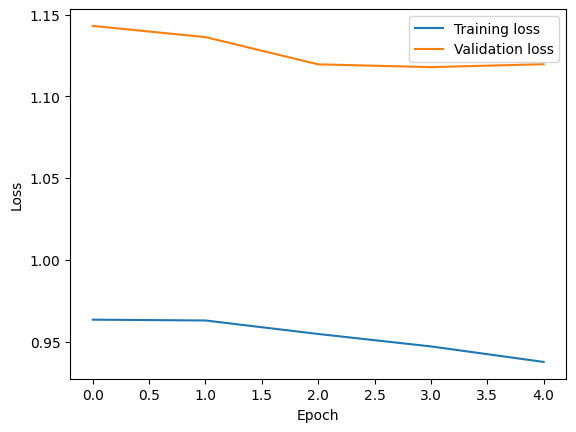

In [29]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [30]:
model.save('saved_models/lstm_shap.h5')

In [32]:
new_df = pd.read_csv('Stocks\IBM_Anomaly.csv')
new_df['index'] = new_df.index
new_df = new_df[['Close','Volume']]
new_df['Diff_Close'] = difference(new_df['Close'].values,interval)
new_df['Diff_Volume'] = difference(new_df['Volume'].values,interval)
new_df = new_df[interval:]
scaled_new_test = scaler.transform(new_df[['Diff_Close','Diff_Volume']])
X_new, Y_new = generate_sequences(scaled_new_test, TIME_STEPS)
new_test_pred = model.predict(X_new, verbose=1)


24/24 [==============================] - 0s 4ms/step


### TimeSHAP code starts here

In [38]:
scaled_train_df = pd.DataFrame(scaled_train, columns=['Diff_Close', 'Diff_Volume'])
scaled_train_df['index'] = scaled_train_df.index
scaled_train_df.head()

,Diff_Close,Diff_Volume,index
0,0.345799,0.209128,0
1,0.047942,0.048473,1
2,0.213417,0.099227,2
3,-0.134083,0.049285,3
4,0.180322,0.072564,4


In [39]:
import timeshap
import tensorflow as tf
from timeshap.utils import calc_avg_event
from timeshap.utils import calc_avg_sequence
from timeshap.utils import get_avg_score_with_avg_event
from timeshap.explainer import local_report

user_model = tf.keras.models.load_model('saved_models\lstm_shap.h5')
model_features = ['Diff_Close', 'Diff_Volume']


average_event = calc_avg_event(scaled_train_df, 
                               numerical_feats=model_features, 
                               categorical_feats=[])
print(average_event)

average_sequence = calc_avg_sequence(scaled_train_df, 
                                     numerical_feats=model_features, 
                                     categorical_feats=[],
                                     model_features=model_features,
                                     entity_col='index')
print(average_sequence)
print(average_sequence.shape)

   Diff_Close  Diff_Volume
0    0.014187     -0.01805
[[ 0.0141868  -0.01804961]]
(1, 2)


In [93]:
# # Trying to apply for the window
# shapes = X_train.shape
# X_train_reshaped = X_train.reshape(shapes[1],shapes[0],shapes[2])

# average_event = []
# for item in X_train_reshaped:
#     df = pd.DataFrame(item, columns=model_features)
#     average_event.append(calc_avg_event(df, numerical_feats=model_features, categorical_feats=[]))

# average_event = np.array(average_event).reshape(5,2)
# print(average_event)

In [40]:
f = lambda x: user_model.predict(x)
avg_score_over_len = get_avg_score_with_avg_event(f, average_event)

1/1 [==============================] - 0s 126ms/step


In [44]:
sample_data = X_train[1].reshape(1,5,2)
##Local Report
plot_feats = {'Diff_Close':'Diff_Close', 'Diff_Volume':'Diff_Volume'}
pruning_dict = {'tol': 0.025}
event_dict = {'rs': 42, 'nsamples': 32000}
feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
cell_dict = {'rs': 42, 'nsamples': 32000, 'top_x_feats': 2, 'top_x_events': 2}
local_report(f, sample_data, pruning_dict, event_dict, feature_dict, cell_dict=cell_dict, entity_uuid=1, entity_col='index', baseline=average_event)

Assuming all features are model features
1/1 [==============================] - 0s 41ms/step
Unable to prune sequence.
1/1 [==============================] - 0s 24ms/step


alt.HConcatChart(...)